# Local temperature response

*The local temperature response per GCM/RCP combination in the 2071 -- 2100 timespan, relative to the 1976 -- 2005 timespan, as function of the global temperature response over the same periods.*

This notebook attempts to recreate Figure 2 from Van den Hurk et al.[<sup>1</sup>](#fn1), also used in the [KNMI '14 climate scenarios](http://www.climatescenarios.nl/).

The data used is CMIP 5 data, which is locally available where this notebook was developed.

Iris is our main analysis toolkit, with a few standard libraries such as numpy, pandas and matplotlib.

There are a few caveats to note in the data analysis, mainly done for simplicity:
- the  data is not gridded to a common grid. It is assumed that either all data grids are the same, or there is negligible difference between the grids. It also means that the area of interest, the Rhine basin, will not exactly match the data grids. Again, this should result in a neglible difference.
- the various available subsets for models are averaged. 
- For some, we are unable to perform this averaging, notable for EC-EARTH, MIROC-ESM-CHEM and HadGEM2-ES. These datasets are left out in further analysis.

Our final results are similar to, but do not exactly match, those by Van den Hurk et al. In paricular, the coefficient of determination, R<sup>2</sup> is smaller for each season. (We also note one model with negative local relative temperature. This is the FIO-ESM model, not used in Van den Hurk et al). We have made several assumptions in the analysis procedure below, which may not precisely correspond to those used by Van den Hurk et al., hence this can explain the differences. Also, our final dataset includes more models and datasets overall than used by Van den Hurk (compare our table near the end with their Table 4 in the Appendix).

A practical note: we have not always included the output of a cell, by putting a semi-colon at the end of the last cell line, as this would become a rather lengthy output and clog up the notebook. It makes it, however, easier for the (interactive) reader to simply remove the semi-colon and see the results.

<span id="#fn1">[1] Van den Hurk, B., Van Oldenborth, G., Lenderink, G., Hazeleger, W., Haarsma, R., de Vries, H., 2014: Drivers of mean climate change around the Netherlands derived from CMIP5. Clim Dyn., 42, 1683--1697. [doi:10.1007/s00382-013-1707-y](https://link.springer.com/article/10.1007/s00382-013-1707-y).</span>

## Basic imports and settings

In [1]:
import warnings
from copy import deepcopy
from collections import defaultdict
from pathlib import Path
from collections.abc import Iterable

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from cftime import datetime, DatetimeNoLeap, DatetimeJulian, Datetime360Day
import iris
import iris.coord_categorisation
from iris.util import unify_time_units
from iris.experimental.equalise_cubes import equalise_attributes

%matplotlib inline

In [2]:
cmip5dir = Path("_data/cmip5")
var = "tas"
seasons = ['djf', 'mam', 'jja', 'son']
coords = {
    'rhinebasin': {'w': 6, 'e': 9, 'n': 52, 's': 47}
}

The RCPs and models are derived dynamically, directly from the available subdirectories in the file system.

In [3]:
rcps = sorted([int(path.stem[3:]) for path in cmip5dir.glob("rcp*")])
rcps

[26, 45, 60, 85]

In [4]:
modelnames = sorted({path.stem for path in cmip5dir.glob(f"rcp*/Amon/{var}/*")}, key=lambda s: s.casefold())
modelnames ;

## Set the area and time constraints

The area constraint is simply based on the "rectangular" grid defined above.

The time constraint is somewhat more problematic: not all datasets use the same style calendar. Therefore, there are multiple variations for the start and end of the timespan set, and a simple if-else chain tests which variation is appropriate. Since this test all happens inside the lambda function, it will slow down things a bit (since this check would happen for every time stamp); to improve the speed, one could define multiple constraints, one for each calendar style, then check the calendar style of the input data beforehand, and apply the appropriate time constraint to the dataset.

In [5]:
coord = coords['rhinebasin']
rhine = iris.Constraint(
        longitude=lambda c: coord['w'] <= c <= coord['e'],
        latitude=lambda c: coord['s'] <= c <= coord['n'])
rhine

Constraint(coord_values={'longitude': <function <lambda> at 0x7fdba3428048>, 'latitude': <function <lambda> at 0x7fdba3428488>})

In [6]:
start1 = DatetimeNoLeap(2071, 1, 1)
stop1 = DatetimeNoLeap(2099, 12, 31)
start2 = DatetimeJulian(2071, 1, 1)
stop2 = DatetimeJulian(2099, 12, 31)
start3 = Datetime360Day(2071, 1, 1)
stop3 = Datetime360Day(2099, 12, 30)
start4 = datetime(2071, 1, 1)
stop4 = datetime(2100, 12, 31)
timespan = iris.Constraint(time=lambda cell: 
                           start1 <= cell.point <= stop1 if isinstance(cell.point, DatetimeNoLeap) 
                           else start2 <= cell.point <= stop2 if isinstance(cell.point, DatetimeJulian)
                           else start3 <= cell.point <= stop3 if isinstance(cell.point, Datetime360Day)
                           else start4 <= cell.point <= stop4)

## Load and extract the data

This is where all the actual work happens; everything else is just bookkeeping.

We create a function for this, since we'll be doing this for all combinations of RCPs and models; and, in fact, for the historical values as well.

The dataset is loaded, or possibly multiple datasets, for cases where the data is spread across multiple files (this spread over multiple files is often across time, but we'll ignore any time limits in the dataset initially, and only bother with that when we extract the relevant timespan. Thanks to Iris's lazy loading, this is still relatively cheap, since it avoids loading the full dataset (just the time dimension dataset)).

Two Iris utilities functions are used, `equalise_attributes` and `unify_time_units`, which equalise attributes such as creation timestamps (which are unimportant for our actual data), so that Iris can properly concatenate all the cubes. Iris does the appropriate thing, concatenating cubes along the time axes (by noting the longitude and latitude coordinates are the same). Note that in a lot of cases, there will simply be one cube loaded anyway, and concatenation is not necessary: we can just use that cube.

We then extract the relevant area and timespan. Multiple areas can be provided (in our case, the Rhine basin area and the global world), and we loop over these areas, performing the extraction on copies of the original data (in our specific case, we could first extract the global area, and then the local area, which avoids a copy, but it's rarely guaranteed one area lies within another. This wouldn't work if, say, Australia was included in the list of areas). Note that "global" is defined by having an area of `None`. Any other areas and timespan are given by Iris constraints, defined above.

Once we have our extract cube, we add seasons, over which we'll aggregate and calculate the mean seasonal value over the timespan.

We also average the area into a single point, with appropriately weighting for the curved Earth.

The output for a single area is then a single cube, with 4 datapoints: one value for each season.

The returned value is these 4-datapoint cubes appended into a list, one per area. We'll need to manually keep track of which list index corresponds to which area.

For datasets that don't cover the relevant timespan (it's assumed all datasets cover the globe, and thus all areas of interest), `None` is returned.

In [7]:
def load_cube(paths, timespan, areas=None):
    if not isinstance(areas, Iterable) or isinstance(areas, (str, bytes)):
        areas = [areas]
    cubes = iris.load([str(path) for path in paths], constraints='air_temperature')
    equalise_attributes(cubes)
    unify_time_units(cubes)
    try:
        cube = cubes.concatenate_cube()
    except iris.exceptions.ConcatenateError as exc:
        warnings.warn(str(exc) + "\nfor: " + str(paths))
        cube = cubes[0]  # iris.load always returns a cubelist, so just take the first element
    
    results = []
    for area in areas:
        excube = cube.copy()
        if area:
            excube = excube.extract(area)
        excube = excube.extract(timespan)
        if excube is None:
            results.append(None)
            continue
            
        iris.coord_categorisation.add_season(excube, 'time', name='season')
    
        weights = iris.analysis.cartography.area_weights(excube)
        excube_av = excube.collapsed(['latitude', 'longitude'], iris.analysis.MEAN, weights=weights)
        excube_season = excube_av.aggregated_by('season', iris.analysis.MEAN)
        results.append(excube_season)

    return results

In [8]:
columns = {f"RCP {rcp/10:0.1f}": 0 for rcp in rcps}
columns['Name'] = modelnames
df = pd.DataFrame(columns)
df.index.rename('Label', inplace=True)
df.head()

,RCP 2.6,RCP 4.5,RCP 6.0,RCP 8.5,Name
Label,,,,,
0,0,0,0,0,ACCESS1-0
1,0,0,0,0,ACCESS1-3
2,0,0,0,0,bcc-csm1-1
3,0,0,0,0,bcc-csm1-1-m
4,0,0,0,0,BNU-ESM


## Loop over all models

This loops over all possible models, across all RCP variations and across all model subsets.

Results which do not contain the relevant timespan (and thus include `None` instead of a cube, see above) are discarded.
Models that do not contain any result (in any of their subsets) are completely removed.

The data structure the results are stored in is a nested dictionary. This is perhaps not the most directly insightful, but since not every model is available for every RCP value, and since the number of subsets varies per model, this is the most flexible way to store our values.

The levels of the dictionary are "rcp", then "model", then the subset, then a list of results per area, then each list item being a cube with 4 seasonal-averaged values. For example, `temp[85]['ACCESS1-0']['1i1p1'][1][2]` would get the summer temperature (`[2]`: the third element of the cube, since the summer is the third season) of the Rhine basin, for the subset 1i1p1 for model ACCESS1-0 for RCP 8.5.

To show progress, we print every RCP iteration, and optionally every model iteration.

In [9]:
%%time
# This takes about 40 minutes

temp = {}
for rcp in rcps:
    print("== RCP:", rcp, "==")
    temp[rcp] = {}
    subdir = cmip5dir / f"rcp{rcp}/Amon/{var}"
    for model in modelnames:
        temp[rcp][model] = {}
        modeldir = subdir / model
        for rdir in modeldir.glob("r*"):
            paths = list(rdir.glob("*.nc"))
            with warnings.catch_warnings():
                warnings.simplefilter("ignore", UserWarning)
                results = load_cube(paths, timespan, areas=[None, rhine])
            # Skip cubes that don't contain the appropriate timespan for any of the regions
            if any(result is None for result in results):
                continue
            temp[rcp][model][rdir.stem] = results
        # Remove cubes that didn't have any appropriate data
        nvalues = len(temp[rcp][model].values())
        if nvalues == 0:
            del temp[rcp][model]
        #print(model, ":", nvalues, "value(s)")

== RCP: 26 ==
== RCP: 45 ==
== RCP: 60 ==
== RCP: 85 ==
CPU times: user 12min 30s, sys: 33.4 s, total: 13min 3s
Wall time: 13min


## Read the historical data

Reading the historical data is very similar to the above code. We first set a new time constraint: 1976 until 2005.

In [10]:
start1 = DatetimeNoLeap(1976, 1, 1)
stop1 = DatetimeNoLeap(2005, 12, 31)
start2 = DatetimeJulian(1976, 1, 1)
stop2 = DatetimeJulian(2005, 12, 31)
start3 = Datetime360Day(1976, 1, 1)
stop3 = Datetime360Day(2005, 12, 30)
start4 = datetime(1976, 1, 1)
stop4 = datetime(2005, 12, 31)
timespan = iris.Constraint(time=lambda cell: 
                           start1 <= cell.point <= stop1 if isinstance(cell.point, DatetimeNoLeap) 
                           else start2 <= cell.point <= stop2 if isinstance(cell.point, DatetimeJulian)
                           else start3 <= cell.point <= stop3 if isinstance(cell.point, Datetime360Day)
                           else start4 <= cell.point <= stop4)

We don't need to iterate over different RCPs. Other than that, we can use the same code, just with one iteration level less.

In [11]:
%%time
# this takes about 20 minutes

histtemp = defaultdict(dict)
basedir = cmip5dir / f"historical/Amon/{var}"
for model in modelnames:
    modeldir = basedir / model
    for subset in modeldir.glob("r*"):
        paths = subset.glob("*.nc")
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", UserWarning)
            results = load_cube(paths, timespan, areas=[None, rhine])
        if any(result is None for result in results):
            continue
        histtemp[model][subset.stem] = results
    nvalues = len(histtemp[model].values())
    if nvalues == 0:
        del histtemp[model]
    print(model, ":", nvalues, "value(s)")

ACCESS1-0 : 3 value(s)
ACCESS1-3 : 3 value(s)
bcc-csm1-1 : 3 value(s)
bcc-csm1-1-m : 3 value(s)
BNU-ESM : 1 value(s)
CanCM4 : 10 value(s)
CanESM2 : 5 value(s)
CCSM4 : 8 value(s)
CESM1-BGC : 1 value(s)
CESM1-CAM5 : 3 value(s)
CESM1-CAM5-1-FV2 : 4 value(s)
CESM1-WACCM : 7 value(s)
CMCC-CESM : 1 value(s)
CMCC-CM : 1 value(s)
CMCC-CMS : 1 value(s)
CNRM-CM5 : 10 value(s)
CSIRO-Mk3-6-0 : 10 value(s)
CSIRO-Mk3L-1-2 : 3 value(s)
EC-EARTH : 7 value(s)
FGOALS-g2 : 5 value(s)
FGOALS-s2 : 2 value(s)
FIO-ESM : 3 value(s)
GFDL-CM2p1 : 10 value(s)
GFDL-CM3 : 5 value(s)
GFDL-ESM2G : 1 value(s)
GFDL-ESM2M : 1 value(s)
GISS-E2-H : 18 value(s)
GISS-E2-H-CC : 1 value(s)
GISS-E2-R : 26 value(s)
GISS-E2-R-CC : 1 value(s)
HadCM3 : 10 value(s)
HadGEM2-AO : 1 value(s)
HadGEM2-CC : 3 value(s)
HadGEM2-ES : 5 value(s)
inmcm4 : 1 value(s)
IPSL-CM5A-LR : 6 value(s)
IPSL-CM5A-MR : 3 value(s)
IPSL-CM5B-LR : 1 value(s)
MIROC-ESM : 3 value(s)
MIROC-ESM-CHEM : 1 value(s)
MIROC4h : 3 value(s)
MIROC5 : 5 value(s)
MPI-ESM-

## Calculate the average tempearture

We average over the different subsets for each model/RCP combination. We do this by using the iris `merge_cube` option: it will merge across a common, increasing coordinate. We add a new "subset" coordinate for this purpose, then merge the list of cubes into one, then average across this subset coordinate.

Some merges fail; for now, these are thrown out and ignored (with a short message printed).

The averaged cube is stored in the `avtemp` variable.

This is also the point where we add the historical data to the original `temp` dictionary, as a special kind of RCP. We alos make a backup (deep copy) of the original data, since we don't want to re-read all the data if we make a mistake below.

In [12]:
# Add the historical temperatures to the other temperature dict, and make a copy of the whole thing.
temp['historical'] = histtemp
backup = deepcopy(temp)

In [13]:
# Start from this cell (the data backup) if a mistake was made anywhere below
temp = deepcopy(backup)

In [14]:
# Average results over subsets
# Skip failed merges
avtemp = defaultdict(dict)
for rcp in temp.keys():
    for model in temp[rcp].keys():
        avtemp[rcp][model] = []
        values = list(temp[rcp][model].values())
        for iregion in range(len(values[0])):
            data = np.array([value[iregion].data for value in values])
            #print(data)
            cubes = iris.cube.CubeList([value[iregion] for value in values])
            if rcp != 'historical':
                df.loc[df['Name'] == model, f"RCP {int(rcp)/10:0.1f}"] = len(cubes)

            for i, cube in enumerate(cubes):
                coordnames = [coord.long_name for coord in cube.coords()]
                if 'subset' in coordnames:
                    cube.remove_coord('subset')                
                cube.add_aux_coord(iris.coords.AuxCoord(i, long_name='subset', units='no_unit'))
            equalise_attributes(cubes)
            try:
                cube = cubes.merge_cube()
            except iris.exceptions.MergeError as exc:
                print('Failed to merge cubes for', model, " -- ", rcp)
                continue
            # We don't need to average if there was only 1 cube (subset) to begin with. 
            # In fact, Iris will complain and throw an exception if we try to average across a dimension with just 1 point.
            if len(cubes) > 1:
                cube = cube.collapsed(['subset'], iris.analysis.MEAN)
            avtemp[rcp][model].append(cube)
avtemp ;

/opt/conda/lib/python3.7/site-packages/iris/coords.py:1357: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'subset'.
  warnings.warn(msg.format(self.name()))
/opt/conda/lib/python3.7/site-packages/iris/coords.py:1357: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'latitude'.
  warnings.warn(msg.format(self.name()))


Failed to merge cubes for EC-EARTH  --  45
Failed to merge cubes for EC-EARTH  --  45
Failed to merge cubes for MIROC-ESM-CHEM  --  45
Failed to merge cubes for MIROC-ESM-CHEM  --  45
Failed to merge cubes for HadGEM2-ES  --  60
Failed to merge cubes for HadGEM2-ES  --  60
Failed to merge cubes for EC-EARTH  --  85
Failed to merge cubes for EC-EARTH  --  85
Failed to merge cubes for HadGEM2-CC  --  85
Failed to merge cubes for HadGEM2-CC  --  85
Failed to merge cubes for CESM1-WACCM  --  historical
Failed to merge cubes for CESM1-WACCM  --  historical
Failed to merge cubes for EC-EARTH  --  historical
Failed to merge cubes for EC-EARTH  --  historical
Failed to merge cubes for GISS-E2-R  --  historical
Failed to merge cubes for GISS-E2-R  --  historical
Failed to merge cubes for HadGEM2-CC  --  historical
Failed to merge cubes for HadGEM2-CC  --  historical
Failed to merge cubes for HadGEM2-ES  --  historical
Failed to merge cubes for HadGEM2-ES  --  historical


Show what data we actually have

In [15]:
df[['Name', 'RCP 2.6', 'RCP 4.5', 'RCP 6.0', 'RCP 8.5']]

,Name,RCP 2.6,RCP 4.5,RCP 6.0,RCP 8.5
Label,,,,,
0,ACCESS1-0,0,1,0,1
1,ACCESS1-3,0,1,0,1
2,bcc-csm1-1,1,1,1,1
3,bcc-csm1-1-m,1,1,1,1
4,BNU-ESM,1,1,0,1
5,CanCM4,0,0,0,0
6,CanESM2,5,5,0,5
7,CCSM4,6,6,6,6
8,CESM1-BGC,0,1,0,1


## Calculate relative temperature responses

We now need to calculate the relative temperature responses, by subtracting the historical averages.

For convenience later on (plotting), we also juggle our dictionary "order" around: since there will be separate subplots for each season, and each plot will have separate colours per RPC, we move these keys to the front. Our new dict, `reltemp`, now follows the order "season", "rcp", "region", "model" (note that the region corresponds to x and y on the plots). See also the last line in the cell below.

In [16]:
# Calculate relative temperatures
# Also flip the season and region to more outer keys

# in `temp` and `avtemp`, the regions are list-based; they'll now be dict based, using the 'global' and 'local' keywords
# Ditto for the seasons: cube access is by index `i`, dict access by abbrevation.
regions = ['global', 'local']  
reltemp = {}
for i, season in enumerate(seasons):                
    reltemp[season] = {}
    for rcp in rcps:
        reltemp[season][rcp] = {region: {} for region in regions}
        for model in avtemp[rcp].keys():
            for region, pred, hist in zip(regions, avtemp[rcp][model], avtemp['historical'][model]):
                reltemp[season][rcp][region][model] = pred[i] - hist[i]

## Plots

We create the plots in the style of Van den Hurk et al., with some minor modifications:
- the identical substring for each subplot is moved out of the individual titles, into the main title
- the axis labels and tick labels are shared
- the x and y scales are identical across the figures

We also calculate the best fit and R<sup>2</sup> in the plotting loop, so that we can directly plot the result as well.

The plotting requires a nested loop:
- an outer loop to step through the four subplots, one for each season
- an inner loop to step through the individual RCPs, so each set of RCP data points is plotted in its own colour.

There are some Matplotlib technicalities as well to consider:
- the linear fit is done first, so that the individual data points can be overplot on top of the fitted lines. This requires an extra inner loop, to collect the data points of the individual RCPs into a single array before fitting.
- matplotlib does not have an option to provide each data point with a numeric symbol. Therefore, the opacity for the data points is turned to zero, and we annotate each point with the relevant number (centered at the point position)
- matplotlib normally uses a symbol or line (in the relevant colour) with black text for the legend. By setting `markersize` to 0, the symbol is not plotted. We set the label text with the appropriate colour, since this defaults to black.
- Matplotlib allows for LaTeX inside labels and titles (text in general), provided LaTeX is installed
- A subplot counter `i` is used to determine which subplots get axis labels or a legend.

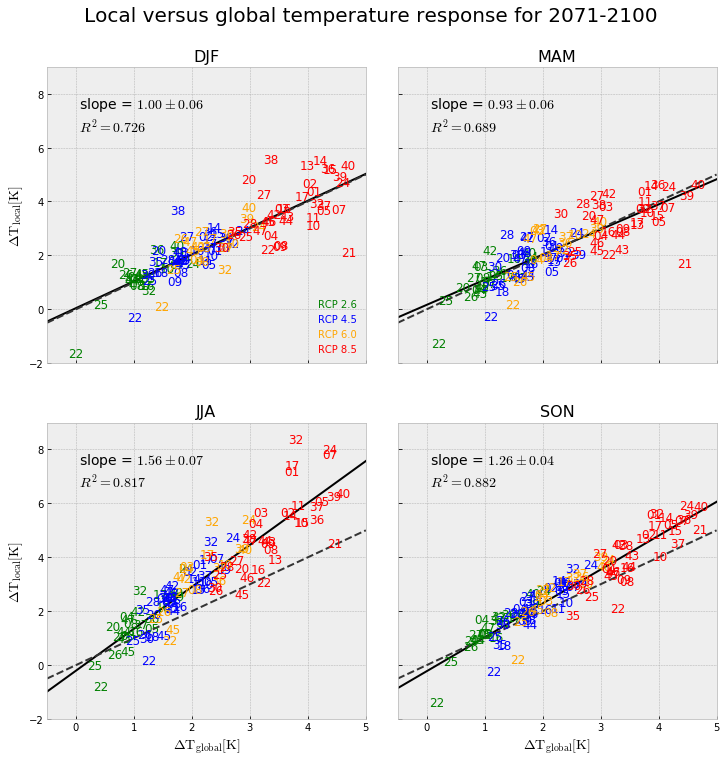

In [17]:
plt.style.use('bmh')

# Fix the colours, to be similar to the KNMI figure
colors = ['green', 'blue', 'orange', 'red']

fig, axes = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(12, 12), gridspec_kw={'hspace': 0.2, 'wspace': 0.1})
plt.suptitle("Local versus global temperature response for 2071-2100", y=0.95, fontsize=20)
axes = axes.flatten()
for iplot, (season, ax) in enumerate(zip(seasons, axes)):
    
    # Linear fit
    xtot = []
    ytot = []
    for rcp in rcps:
        xtot.append([cube.data for cube in reltemp[season][rcp]['global'].values()])
        ytot.append([cube.data for cube in reltemp[season][rcp]['local'].values()])
    x = np.concatenate(xtot)
    y = np.concatenate(ytot)
    coeffs, covar = np.polyfit(x, y, 1, cov=True)
    stderrs = np.sqrt([covar[0,0], covar[1,1]])
    poly = np.poly1d(coeffs)
    
    yfit = poly(x)
    r2 = np.sum((yfit - y.mean())**2) / np.sum((y - y.mean())**2)    
    plt.text(0.1, 0.86, f"slope = ${coeffs[0]:.2f} \pm {stderrs[0]:.2f}$", fontsize=14, transform=ax.transAxes)
    plt.text(0.1, 0.78, f"$R^2 = {r2:.3f}$", fontsize=14, transform=ax.transAxes)
    x = [-0.5, 5]
    ax.plot(x, poly(x), '-', color='black')
    poly = np.poly1d([1, 0])
    ax.plot(x, poly(x), '--', color='#333333')

    # Plot individual RCPs
    for ircp, rcp in enumerate(rcps):
        names = [name for name in reltemp[season][rcp]['global'].keys()]
        x = xtot[ircp]
        y = ytot[ircp]
        xtot.append(np.array(x))
        ytot.append(np.array(y))
        inames = [i for i, name in enumerate(modelnames) if name in names]
        plot = ax.plot(x, y, 'o', label=f"RCP {rcp/10:.1f}", alpha=0, color=colors[ircp])
        # Alternative way to obtain the plot colours, if we had let Matplotlib use its defaults
        #color = plot[0].get_color()
        for iname, xx, yy in zip(inames, x, y):
            ax.annotate(f"{iname+1:02d}", (xx, yy), color=colors[ircp], fontsize=12, horizontalalignment='center', verticalalignment='center')
    
    # subplot details
    ax.set_title(season.upper(), fontsize=16)
    ax.axis([-0.5, 5, -2, 9]) 
    if iplot in [2, 3]:
        ax.set_xlabel('$\Delta \\mathrm{T}_{\\mathrm{global}} [\mathrm{K}]$', fontsize=14)
    if iplot in [0, 2]:
        ax.set_ylabel('$\Delta \\mathrm{T}_{\\mathrm{local}}[\mathrm{K}]$', fontsize=14)
    if iplot == 0:
        legend = ax.legend(loc='lower right', frameon=False, markerscale=0)
        for color, text in zip(colors, legend.get_texts()):
            text.set_color(color)
        
# Save the figure to file as well
plt.savefig('temp-response-rhine.png')